In [1]:
# imports
import wrangle
import f_engineer
import prepare
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
import f_engineer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import  mean_squared_error, explained_variance_score
# remove warnings
import warnings
warnings.filterwarnings('ignore')


Acquire/Wrangle

In [2]:
# utilize wrangle.py to load data
df = wrangle.get_zillow_project_data()
df.head() # check the first 5 rows of the data

Let me get that for you...


,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,logerror,transactiondate,taxamount
0,12797413,2.0,4.0,1178.0,6037.0,6213.0,1951.0,223459.0,0.038661,2017-01-11,2864.03
1,10808520,3.0,3.0,2287.0,6037.0,10249.0,1978.0,753587.0,0.000974,2017-01-11,9115.66
2,12961285,5.0,5.0,3135.0,6037.0,11772.0,1951.0,2132481.0,1.457087,2017-01-11,24025.64
3,14195775,2.5,4.0,2990.0,6059.0,15300.0,1982.0,599991.0,0.066588,2017-01-11,7187.12
4,11243022,2.0,2.0,1080.0,6037.0,108228.0,1973.0,130028.0,-0.008227,2017-01-11,1559.50


In [3]:
# identify the tax rate
# create a new dataframe with 'taxamount', 'taxvaluedollarcnt', 'fips'
tax_df = df[['taxamount', 'taxvaluedollarcnt', 'fips']]

# created a new column for tax rate
tax_df['tax_rates'] = round((tax_df.taxamount / tax_df.taxvaluedollarcnt) * 100, 2) 

los_angeles_median = tax_df[tax_df.fips == 6037].tax_rates.median() # get the median tax rate for Los Angeles
orange_median = tax_df[tax_df.fips == 6059].tax_rates.median() # get the median tax rate for Orange
ventura_median = tax_df[tax_df.fips == 6111].tax_rates.median() # get the median tax rate for Ventura

print("Median tax rate for Los Angelos", los_angeles_median)
print("Median tax rate for Onange", orange_median)
print("Median tax rate for Ventura", ventura_median)

Median tax rate for Los Angelos 1.27
Median tax rate for Onange 1.16
Median tax rate for Ventura 1.12


In [4]:
# create a function that identifies the tax rate for each county
def get_tax_rate(df):
    tax_df = df[['taxamount', 'taxvaluedollarcnt', 'fips']]

    # created a new column for tax rate
    tax_df['tax_rates'] = round((tax_df.taxamount / tax_df.taxvaluedollarcnt) * 100, 2) 

    los_angeles_median = tax_df[tax_df.fips == 6037].tax_rates.median() # get the median tax rate for Los Angeles
    orange_median = tax_df[tax_df.fips == 6059].tax_rates.median() # get the median tax rate for Orange
    ventura_median = tax_df[tax_df.fips == 6111].tax_rates.median() # get the median tax rate for Ventura

    print("Median tax rate for Los Angelos", los_angeles_median)
    print("Median tax rate for Onange", orange_median)
    print("Median tax rate for Ventura", ventura_median)
    return
get_tax_rate(df)

Median tax rate for Los Angelos 1.27
Median tax rate for Onange 1.16
Median tax rate for Ventura 1.12


In [5]:
# prep the data for modeling and feature engineering
df = wrangle.zillow_proj_prep(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51834 entries, 0 to 52441
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        51834 non-null  float64
 1   bedrooms         51834 non-null  float64
 2   sqft             51834 non-null  float64
 3   county_fips      51834 non-null  float64
 4   lotsqft          51834 non-null  float64
 5   year             51834 non-null  float64
 6   value            51834 non-null  float64
 7   logerror         51834 non-null  float64
 8   transactiondate  51834 non-null  object 
dtypes: float64(8), object(1)
memory usage: 4.0+ MB


In [6]:
# check data for nulls
df.isnull().sum()

bathrooms          0
bedrooms           0
sqft               0
county_fips        0
lotsqft            0
year               0
value              0
logerror           0
transactiondate    0
dtype: int64

In [7]:
df.head()

,bathrooms,bedrooms,sqft,county_fips,lotsqft,year,value,logerror,transactiondate
0,2.0,4.0,1178.0,6037.0,6213.0,1951.0,223459.0,0.038661,2017-01-11
1,3.0,3.0,2287.0,6037.0,10249.0,1978.0,753587.0,0.000974,2017-01-11
2,5.0,5.0,3135.0,6037.0,11772.0,1951.0,2132481.0,1.457087,2017-01-11
3,2.5,4.0,2990.0,6059.0,15300.0,1982.0,599991.0,0.066588,2017-01-11
4,2.0,2.0,1080.0,6037.0,108228.0,1973.0,130028.0,-0.008227,2017-01-11


In [8]:
# remove outliers
df = prepare.remove_outliers_fips(df, 1.5)

In [9]:
# split the dataframe into train, validate, and test
train, validate, test = wrangle.split_dataframe(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(22979, 9)
(9849, 9)
(8208, 9)


EXPLORE

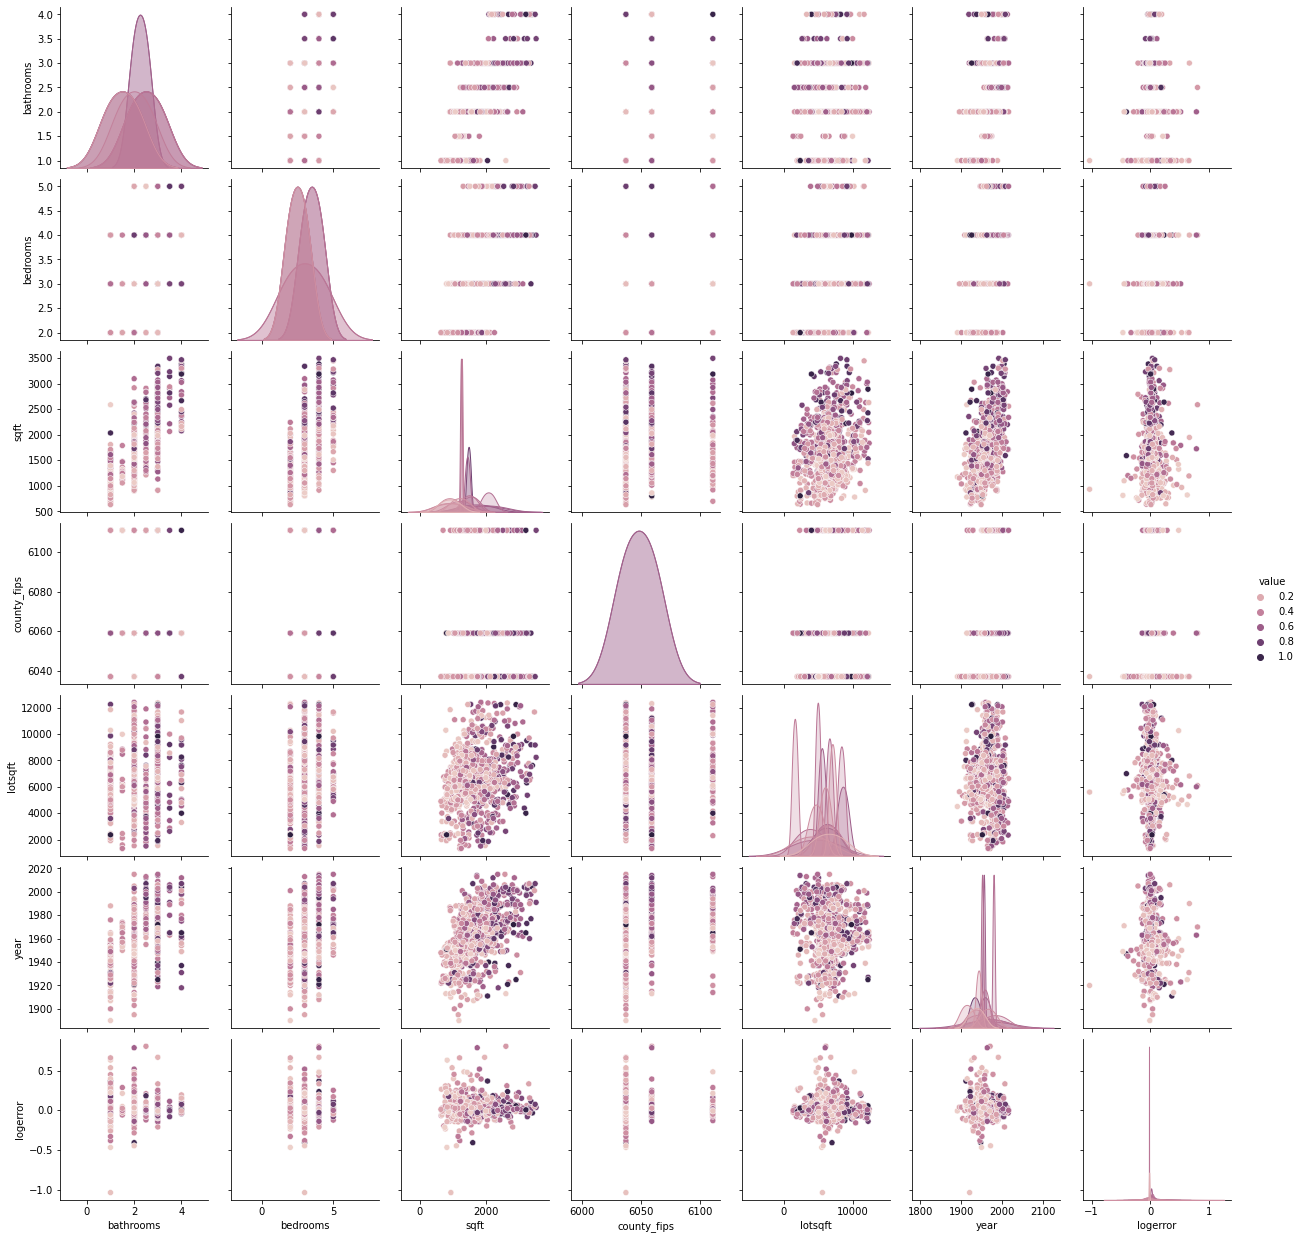

In [10]:
# create sample of train dataset for easier visualization
train_sample = train.sample(n=1000)
# create a pairplot of the sampled train dataset
sns.pairplot(train_sample, hue = ('value'))

In [11]:
train_sample.corr() # check for correlations

,bathrooms,bedrooms,sqft,county_fips,lotsqft,year,value,logerror
bathrooms,1.000000,0.588005,0.767909,0.141570,0.131948,0.586737,0.350450,0.015250
bedrooms,0.588005,1.000000,0.612973,0.144333,0.193585,0.411740,0.201150,0.012933
sqft,0.767909,0.612973,1.000000,0.133187,0.252180,0.518643,0.420870,0.059453
county_fips,0.141570,0.144333,0.133187,1.000000,0.025145,0.293162,0.119706,0.031357
lotsqft,0.131948,0.193585,0.252180,0.025145,1.000000,-0.003751,0.007728,-0.016445
year,0.586737,0.411740,0.518643,0.293162,-0.003751,1.000000,0.200071,-0.031476
value,0.350450,0.201150,0.420870,0.119706,0.007728,0.200071,1.000000,-0.015080
logerror,0.015250,0.012933,0.059453,0.031357,-0.016445,-0.031476,-0.015080,1.000000


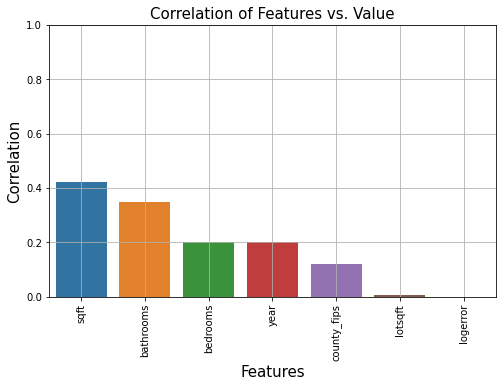

In [12]:

# correlation of all features vs. value
sample_corr = train_sample.corr()['value'].sort_values(ascending=False)
# remove value column from correlation
sample_corr = sample_corr.drop('value')
# visualize of sample_correlation of all features vs. value
plt.figure(figsize=(8,5))
sns.barplot(sample_corr.index, sample_corr.values)
plt.xticks(rotation=90)
# add labels to the plot
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Correlation of Features vs. Value', fontsize=15)
plt.grid(True)
plt.ylim(0,1)
plt.show()

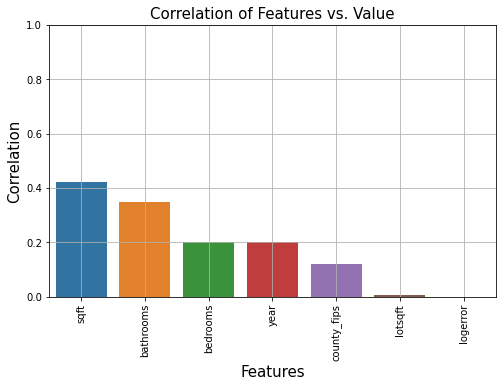

In [13]:
# create a function for calculating the correlation of a feature
def sample_corr(df, feature):
    corr = df.corr()[feature].sort_values(ascending=False)
    corr = corr.drop(feature)
    plt.figure(figsize=(8,5))
    sns.barplot(corr.index, corr.values)
    plt.xticks(rotation=90)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Correlation', fontsize=15)
    plt.title('Correlation of Features vs. Value', fontsize=15)
    plt.grid(True)
    plt.ylim(0,1)
    plt.show()
sample_corr(train_sample, 'value')
    

In [14]:
train.head()

,bathrooms,bedrooms,sqft,county_fips,lotsqft,year,value,logerror,transactiondate
31495,2.0,3.0,1880.0,6037.0,7614.0,1951.0,482254.0,-0.021008,2017-06-13
29824,2.5,3.0,1889.0,6059.0,4772.0,1988.0,711516.0,0.038721,2017-05-31
41480,2.0,3.0,1834.0,6059.0,7740.0,1955.0,299124.0,-0.018275,2017-08-03
8979,3.0,2.0,1791.0,6037.0,11074.0,1937.0,127120.0,0.021883,2017-03-02
2019,2.5,3.0,2573.0,6111.0,6305.0,2006.0,629603.0,0.044443,2017-01-23


In [15]:

def pearson_corr(df, target):
    feature = train[['sqft', 'bathrooms', 'bedrooms', 'lotsqft']]
    """
    Calculate the pearson correlation between the target and feature
    """
    # create a loop that calculates the pearson correlation for each feature
    for i in feature.columns:
        # calculate the pearson correlation
        corr = pearsonr(df[target], df[i])
        # print the feature and the correlation
        print(i, corr) 
pearson_corr(train, 'value')

sqft (0.427263143733718, 0.0)
bathrooms (0.3598203087567747, 0.0)
bedrooms (0.18537859998260434, 9.455186615396512e-177)
lotsqft (0.016693804514389884, 0.011386002192380194)


In [16]:
def ttest_corr(df, target):
    feature = train[['sqft', 'bathrooms', 'bedrooms', 'lotsqft']]
    """
    Calculate the ttest correlation between the target and feature
    """
    # create a loop that calculates the ttest correlation for each feature
    for i in feature.columns:
        # calculate the ttest correlation
        corr = ttest_ind(df[target], df[i])
        # print the feature and the correlation
        print(i, corr)
ttest_corr(train, 'value')

sqft Ttest_indResult(statistic=232.03387068459054, pvalue=0.0)
bathrooms Ttest_indResult(statistic=233.10299463400494, pvalue=0.0)
bedrooms Ttest_indResult(statistic=233.10226494673805, pvalue=0.0)
lotsqft Ttest_indResult(statistic=228.81637038310328, pvalue=0.0)


In [17]:
# Correlation tests are used to check if two features are correlated
# the closer the correlation is to 1, the more correlated the features are
# value and sqft pearsonr
r, p = pearsonr(train.value, train.sqft)
r,p

(0.427263143733718, 0.0)

In [18]:
# value and bathrooms pearsonr
r, p = pearsonr(train.value, train.bathrooms)
r,p

(0.3598203087567747, 0.0)

In [19]:
# value and bathrooms pearsonr
r, p = pearsonr(train.value, train.bathrooms)
r,p

(0.3598203087567747, 0.0)

In [20]:
# value and lotsqft pearsonr
r, p = pearsonr(train.value, train.lotsqft)
r,p


(0.016693804514389884, 0.011386002192380194)

In [21]:
# value and area ttest_ind
f, p = ttest_ind(train.value, train.sqft)
f, p

(232.03387068459054, 0.0)

In [22]:
# t test are used to check if two features are statistically different
# the closer the p value is to 0, the more statistically significant the test
# value and bedrooms ttest_ind
f, p = ttest_ind(train.value, train.bedrooms)
f, p

(233.10226494673805, 0.0)

In [23]:
# value and bathrooms ttest_ind
f, p = ttest_ind(train.value, train.bathrooms)
f, p

(233.10299463400494, 0.0)

In [24]:
# value and lotsqft ttest_ind
f, p = ttest_ind(train.value, train.lotsqft)
f, p

(228.81637038310328, 0.0)

In [25]:
# group by county_fips and calculate the mean value
train.groupby('county_fips').mean()
# 6037 = Los Angeles
# 6059 = Orange County
# 6111 = Riverside County

,bathrooms,bedrooms,sqft,lotsqft,year,value,logerror
county_fips,,,,,,,
6037.0,1.944966,3.079434,1555.092305,6787.395294,1955.269205,324077.709814,0.015784
6059.0,2.295270,3.376788,1845.313394,6065.613784,1971.989272,433435.913199,0.024106
6111.0,2.245416,3.473546,1807.940807,7044.084861,1974.721320,408538.459403,0.010836


In [26]:
# Create subsets with only predictive features (x)
# Create subsets with only target feature (y)
X_train = train.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
y_train = train.value
X_validate = validate.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
y_validate = validate.value
X_test = test.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
y_test = test.value

In [27]:
# Create a function that creates your X and y dataframes
def create_X_y(train, validate, test):
    # Create subsets with only predictive features (x)
    X_train = train.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
    y_train = train.value
    X_validate = validate.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
    y_validate = validate.value
    X_test = test.drop(columns=['value', 'transactiondate', 'logerror', 'county_fips'])
    y_test = test.value
    return X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape
create_X_y(train, validate, test)

((22979, 5), (22979,), (9849, 5), (9849,), (8208, 5), (8208,))

In [28]:
X_train_scaled = f_engineer.scale_minmax(X_train)
X_validate_scaled = f_engineer.scale_minmax(X_validate)
X_test_scaled = f_engineer.scale_minmax(X_test)

print(X_train_scaled.shape)
print(X_validate_scaled.shape)
print(X_test_scaled.shape)

(22979, 5)
(9849, 5)
(8208, 5)


In [29]:
# create a function that scales your X train, validate, and test dataframes
def scale_X(train, validate, test):
    X_train_scaled = f_engineer.scale_minmax(X_train)
    X_validate_scaled = f_engineer.scale_minmax(X_validate)
    X_test_scaled = f_engineer.scale_minmax(X_test)
    return X_train_scaled, X_validate_scaled, X_test_scaled


In [30]:
# Use KBest to select features
kbest = SelectKBest(f_regression, k=3)
kbest.fit(X_train, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x7ff54ac94310>)

In [31]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train.columns)
kbest_results

,p,f
bathrooms,0.000000e+00,3417.285410
bedrooms,9.455187e-177,817.710591
sqft,0.000000e+00,5131.271628
lotsqft,1.138600e-02,6.405087
year,1.201392e-302,1425.193007


In [32]:
X_train.columns[kbest.get_support()]

Index(['bathrooms', 'sqft', 'year'], dtype='object')

In [33]:
# create kbest function for X_train and y_train
def kbest_X_y(X, y):
    #create a copy of y_train
    y_train = y.value
    kbest = SelectKBest(f_regression, k=3)
    kbest.fit(X, y)
    kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X.columns)
    index = X.columns[kbest.get_support()]
    return print(kbest_results, print(index))
kbest_X_y(X_train, y_train)


AttributeError: 'Series' object has no attribute 'value'

In [ ]:
# Progressively eliminate features based on importance to the model
f_engineer.rfe(X_train, y_train, 3)

In [ ]:
# Convert target series back into pd dataframe
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

y_train.head()

In [ ]:
# Create a median baseline
price_pred_median = y_train.value.median()
y_train['price_pred_median'] = price_pred_median
y_validate['price_pred_median'] = price_pred_median
y_test['price_pred_median'] = price_pred_median

y_train.head()

In [ ]:
# RMSE of price_pred_median (median baseline)
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_median) ** .5
rmse_test = mean_squared_error(y_test.value, y_test.price_pred_median) ** .5

r2_train = explained_variance_score(y_train.value, y_train.price_pred_median)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_median)


print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2), 
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2)
     )

In [ ]:
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_median'])

In [ ]:
# create a function of the RMSE and R^2
def rmse_r2(y_train, y_validate, y_test):
    # create a median baseline
    rmse_train = mean_squared_error(y_train.value, y_train.price_pred_median) ** .5
    rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_median) ** .5
    rmse_test = mean_squared_error(y_test.value, y_test.price_pred_median) ** .5
    # RMSE of price_pred_median (median baseline)
    r2_train = explained_variance_score(y_train.value, y_train.price_pred_median)
    r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_median)
    p = print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2), 
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2)
     )
    plot = sns.scatterplot(x=y_train['value'], y=y_train['price_pred_median'])
    return p, plot

rmse_r2(y_train, y_validate, y_test)

In [ ]:
# Linear regression, OLS

# Create the object
lm = LinearRegression(normalize=True)

# Fit the object
lm.fit(X_train_scaled, y_train.value)

# Use the object
y_train['price_pred_lm'] = lm.predict(X_train)
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_lm) ** (1/2)

y_validate['price_pred_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_lm) ** (1/2)

r2_train = explained_variance_score(y_train.value, y_train.price_pred_lm)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_lm)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

In [ ]:
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_lm'])

In [ ]:
# create a function of the Linear regression, OLS
def lm_ols(y_train, y_validate, y_test):
    # Create the object
    lm = LinearRegression(normalize=True)
    # Fit the object
    lm.fit(X_train_scaled, y_train.value)
    # Use the object
    y_train['price_pred_lm'] = lm.predict(X_train)
    rmse_train = mean_squared_error(y_train.value, y_train.price_pred_lm) ** (1/2)
    y_validate['price_pred_lm'] = lm.predict(X_validate)
    rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_lm) ** (1/2)
    r2_train = explained_variance_score(y_train.value, y_train.price_pred_lm)
    r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_lm)
    p = print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))
    plot = sns.scatterplot(x=y_train['value'], y=y_train['price_pred_lm'])
    return p, plot
lm_ols(y_train, y_validate, y_test)


In [ ]:
# Create the object
lars = LassoLars(alpha=1)

# Fit the model to train. 
# We must specify the column in y_train, 
# because we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.value)

# predict train
y_train['price_pred_lars'] = lars.predict(X_train)

# evaluate using rmse
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(X_validate)
y_test['price_pred_lars'] = lars.predict(X_test)

# evaluate using rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_lars) ** (1/2)

r2_train = explained_variance_score(y_train.value, y_train.price_pred_lars)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_lars)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))


In [ ]:
# visualize the coefficients
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_lars'], alpha=0.5)



In [ ]:
# create a function of the Lasso + Lars
def lars_lasso(y_train, y_validate, y_test):
    # Create the object
    lars = LassoLars(alpha=1)

    # Fit the model to train. 
    # We must specify the column in y_train, 
    # because we have converted it to a dataframe from a series!
    lars.fit(X_train, y_train.value)

    # predict train
    y_train['price_pred_lars'] = lars.predict(X_train)

    # evaluate using rmse
    rmse_train = mean_squared_error(y_train.value, y_train.price_pred_lars) ** (1/2)

    # predict validate
    y_validate['price_pred_lars'] = lars.predict(X_validate)
    y_test['price_pred_lars'] = lars.predict(X_test)

    # evaluate using rmse
    rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_lars) ** (1/2)

    r2_train = explained_variance_score(y_train.value, y_train.price_pred_lars)
    r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_lars)

    p= print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))
    plot = sns.scatterplot(x=y_train['value'], y=y_train['price_pred_lars'], alpha=0.5)
    return p, plot
lars_lasso(y_train, y_validate, y_test)


In [ ]:
# Create the object
glm = TweedieRegressor(power=1, alpha=0)


# Fit the model to train. 
# We must specify the column in y_train, 
# becuase we  converted it to a dataframe from a series! 
glm.fit(X_train, y_train.value)

# predict train
y_train['price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_glm) ** (1/2)

r2_train = explained_variance_score(y_train.value, y_train.price_pred_glm)
r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_glm)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

In [ ]:
sns.scatterplot(x=y_train['value'], y=y_train['price_pred_glm'])

In [ ]:
sns.scatterplot(x=y_test['value'], y=y_test['price_pred_lars'])

In [ ]:
# create a function of the GLM
def glm_tweedie(y_train, y_validate, y_test):
    # Create the object
    glm = TweedieRegressor(power=1, alpha=0)

    # Fit the model to train. 
    # We must specify the column in y_train, 
    # becuase we  converted it to a dataframe from a series! 
    glm.fit(X_train, y_train.value)
    # predict train
    y_train['price_pred_glm'] = glm.predict(X_train)
    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.value, y_train.price_pred_glm) ** (1/2)
    # predict validate
    y_validate['price_pred_glm'] = glm.predict(X_validate)
    y_test['price_pred_glm'] = glm.predict(X_test)
    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.value, y_validate.price_pred_glm) ** (1/2)
    # evaluate: r2
    r2_train = explained_variance_score(y_train.value, y_train.price_pred_glm)
    r2_validate = explained_variance_score(y_validate.value, y_validate.price_pred_glm)
    
    p = print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2),
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))
    # plot
    plot = sns.scatterplot(x=y_train['value'], y=y_train['price_pred_glm'], alpha=0.5)
    plot2 = sns.scatterplot(x=y_test['value'], y=y_test['price_pred_lars'])

    # create subplots for the two plots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].set_title('GLM Tweedie, power=1 & alpha=0')
    axs[0].set_xlabel('Actual Price')
    axs[0].set_ylabel('Predicted Price')
    axs[0].set_ylim(0, max(y_train.value) + 100)
    axs[0].set_xlim(0, max(y_train.value) + 100)
    axs[0].scatter(y_train.value, y_train.price_pred_glm, alpha=0.5)
    axs[1].set_title('Lasso + Lars')
    axs[1].set_xlabel('Actual Price')
    axs[1].set_ylabel('Predicted Price')
    axs[1].set_ylim(0, max(y_test.value) + 100)
    axs[1].set_xlim(0, max(y_test.value) + 100)
    axs[1].scatter(y_test.value, y_test.price_pred_lars, alpha=0.5)
    return p, plot, plot2
glm_tweedie(y_train, y_validate, y_test)

In [ ]:
# predict test
y_test['price_pred_lars'] = lars.predict(X_test)

# evaluate using rmse
rmse_test = mean_squared_error(y_test.value, y_test.price_pred_lars) ** (1/2)

r2_test = explained_variance_score(y_test.value, y_test.price_pred_lars)

print("RMSE for Lasso + Lars\n",
      "Test/Out-of-Sample: ", round(rmse_test,2),
      "\n",
      "\n",
      "R^2 using Mean\n",
      "Test/Out-of-Sample: ", round(r2_test, 2))

In [ ]:
sns.scatterplot(x=y_test['value'], y=y_test['price_pred_lars'])

In [ ]:
# create a function that predicts test data
def lars_test(X_test, y_test):
    y_test['price_pred_lars'] = lars.predict(X_test)

    # evaluate using rmse
    rmse_test = mean_squared_error(y_test.value, y_test.price_pred_lars) ** (1/2)

    r2_test = explained_variance_score(y_test.value, y_test.price_pred_lars)

    p = print("RMSE for Lasso + Lars\n",
      "Test/Out-of-Sample: ", round(rmse_test,2),
      "\n",
      "\n",
      "R^2 using Mean\n",
      "Test/Out-of-Sample: ", round(r2_test, 2))
    plot = sns.scatterplot(x=y_test['value'], y=y_test['price_pred_lars'])
    return p, plot
lars_test(X_test, y_test)



The three most predictive features for tax value are: area, bedroom, bathroom.

LassaLars was best model as determined by RMSE and R^2.

County had an effect on tax value, but was not one of the most important drivers.